# Training

This example demonstrates the basics of training a neural operator in Continuity.

In [1]:
import torch
import matplotlib.pyplot as plt
torch.manual_seed(0)
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)
plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)
plt.rcParams["legend.framealpha"] = 0.0

## Operator

Given two sets of functions $U$ and $V$, assume we want to learn an operator

\begin{align*}
G: U &\to V, \\
   u &\mapsto v,
\end{align*}

that maps functions $u \in U$ to functions $v \in V$.

In this example, we choose to learn the operator that maps the set of functions

$$
U = \{ u_a(x) = \sin(a \pi x) \mid a \in [1, 2] \}
$$

to the set of functions

$$
V = \{ v_a(x) = a \pi \cos(a \pi y) \mid a \in [1, 2] \},
$$

such that $G(u_a) = v_a$. Let's consider $x, y \in [0, 1]$ and start with
the visualization of some functions in $U$ and $V$.

In [2]:
import torch
from continuity.discrete import RegularGridSampler
from continuity.data.function import FunctionSet

U = FunctionSet(lambda a: lambda x: torch.sin(a * torch.pi * x))
V = FunctionSet(lambda a: lambda y: a * torch.pi * torch.cos(a * torch.pi * y))

a = torch.Tensor([1., 1.5, 2.])

u_a = U(a)
v_a = V(a)

print(f"len(u) = {len(u_a)}  ", f"len(v) = {len(v_a)}")

len(u) = 3   len(v) = 3


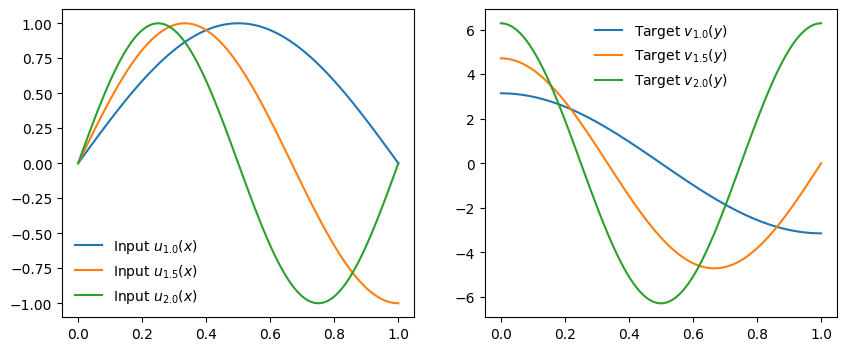

In [3]:
x = torch.linspace(0, 1, 100)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
for i in range(3):
    ax[0].plot(x, u_a[i](x), label=r"Input $u_{"+f"{a[i]:.1f}"+"}(x)$")
    ax[1].plot(x, v_a[i](x), label=r"Target $v_{"+f"{a[i]:.1f}"+"}(y)$")
ax[0].legend()
ax[1].legend()
plt.show()

!!! note

    In these examples, we hide the code for visualization, but you can find it in the source code of this notebook.

## Discretization
Operator learning is about learning mappings between infinite dimensional spaces.
To work with infinite-dimensional objects numerically, we have to discretize
the input and output function somehow. In Continuity, this is done by point-wise
evaluation.

Discretized functions can be collected in an `OperatorDataset` for
operator learning.
The `OperatorDataset` is a container of discretizations of input-output functions.
It contains tuples (`x`, `u`, `y`, `v`) of tensors, where every sample consists of

  - the sensor positions `x`,
  - the values `u` of the input function at the sensor positions,
  - the evaluation points `y`, and
  - the values `v` of the output functions at the evaluation points.

If we already have a `FunctionSet`, we can use the `FunctionOperatorDataset` to
sample elements $u \in U$ and $v \in V$ evaluated at sampled positions.

In [4]:
from continuity.data.function import FunctionOperatorDataset

a_sampler = RegularGridSampler([1.], [2.])
x_sampler = RegularGridSampler([0.], [1.])

n_sensors = 32
n_observations = 128

dataset = FunctionOperatorDataset(
    U, x_sampler, n_sensors,
    V, x_sampler, n_sensors,
    a_sampler, n_observations,
)

In [5]:
print(dataset.shapes)

OperatorShapes(x=TensorShape(num=32, dim=1), u=TensorShape(num=32, dim=1), y=TensorShape(num=32, dim=1), v=TensorShape(num=32, dim=1))


Split data set into training, validation and test set.

In [6]:
from continuity.data.utility import split

train_dataset, test_val_dataset = split(dataset, 0.75)
val_dataset, test_dataset = split(test_val_dataset, 0.5)

In [7]:
print(f"{len(train_dataset) = } ", f"{len(val_dataset) = } ", f"{len(test_dataset) = }")

len(train_dataset) = 96  len(val_dataset) = 16  len(test_dataset) = 16


## Neural Operator

In order to learn the operator $G$ with a neural network, we can train a _neural operator_.

A neural operator $G_\theta$ takes an input function $u$, evaluated at sensor positions $x$,
and maps it to a function $v$ evaluated at (possibly different) evaluation points $y$, such that
$$
v(y) = G(u)(y) \approx G_\theta\left(x, u(x), y\right).
$$

In this example, we train a DeepONet, a common neural operator architecture
motivated by the universal approximation theorem for operators.

In [8]:
from continuity.operators import DeepONet
operator = DeepONet(shapes=dataset.shapes, trunk_depth=8)

## Training

Continuity provides the `Trainer` class
which implements a default training loop for neural operators.
It is instantiated with an `Operator`, an optimizer (`Adam(lr=1e-3)` by default), 
and a loss function (`MSELoss` by default).

The `fit` method takes an `OperatorDataset` and trains the neural operator 
up to a given tolerance on the training data (but at most for a
given number of `epochs`, 1000 by default).

Model parameters: 11152
Device: mps
Epoch 779:   loss/train = 9.3721e-04   loss/val = 1.1163e-03   (0.028 s/epoch)


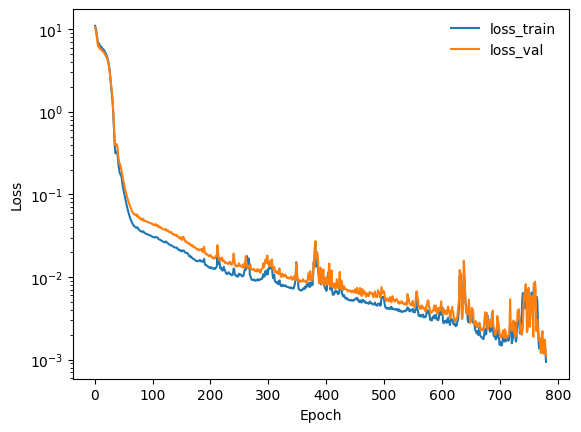

In [9]:
from continuity.trainer import Trainer
from continuity.trainer.callbacks import PrintTrainingLoss, LearningCurve

trainer = Trainer(operator, lr=5e-4)

callbacks = [PrintTrainingLoss(), LearningCurve()]
trainer.fit(train_dataset, tol=1e-3, callbacks=callbacks, val_dataset=val_dataset)

## Evaluation

The mapping of the trained operator can be evaluated at arbitrary positions,
so let's plot the prediction of $G_\theta$ on a fine resolution along with
the target function.

In [10]:
x, u, y, v = val_dataset[0:1]

y_plot = torch.linspace(0, 1, 100).reshape(1, -1, 1)
v_pred = operator(x, u, y_plot)

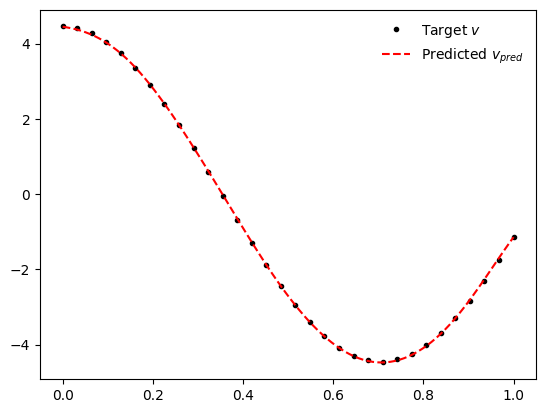

In [11]:
plt.plot(y.squeeze(), v.squeeze(), "k.", label=r"Target $v$")
plt.plot(y_plot.squeeze(), v_pred.squeeze().detach(), "r--", label=r"Predicted $v_{pred}$")
plt.legend()
plt.show()

Let us evaluate some training metrics, e.g., a validation error.

In [12]:
from continuity.data import dataset_loss

loss_train = dataset_loss(train_dataset, operator)
loss_val = dataset_loss(val_dataset, operator)
loss_test = dataset_loss(test_dataset, operator)

In [13]:
print(f"loss/train = {loss_train:.4e}")
print(f"loss/val   = {loss_val:.4e}")
print(f"loss/test  = {loss_test:.4e}")

loss/train = 8.8527e-04
loss/val   = 1.1163e-03
loss/test  = 7.2871e-04


As you can observe, the neural operator is able to learn the operator $G$ and
generalizes well to unseen data. That's the basics!